In [1]:
import torch
import sys
import yaml
from torchvision import transforms, datasets
import torchvision
import numpy as np
import os
from sklearn import preprocessing
from torch.utils.data.dataloader import DataLoader

In [2]:
sys.path.append('../')
from models.resnet_base_network import ResNet18

In [3]:
batch_size = 512
data_transforms = torchvision.transforms.Compose([transforms.ToTensor()])

In [4]:
config = yaml.load(open("../config/config.yaml", "r"), Loader=yaml.FullLoader)

In [5]:
import shutil
import random

# Configuration
batch_size = 512
transform = transforms.Compose([transforms.ToTensor()])

# Load config file
config = yaml.load(open("../config/config.yaml", "r"), Loader=yaml.FullLoader)

# Paths for pre-split train and test directories
train_dir = "/nmhs2/prema/imageprocessing/train_test_data/paddy_train"
test_dir = "/nmhs2/prema/imageprocessing/train_test_data/paddy_test"



In [10]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Check input shape of first image
print("Input shape:", train_dataset[0][0].shape)  # [C, H, W]

Input shape: torch.Size([3, 512, 512])


In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, drop_last=False, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, drop_last=False, shuffle=True)

In [12]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
encoder = ResNet18(**config['network'])
output_feature_dim = encoder.projetion.net[0].in_features

In [13]:
#load pre-trained parameters
load_params = torch.load(os.path.join('/nmhs2/prema/imageprocessing/byol/PyTorch-BYOL/runs/byol_experiment/checkpoints/model.pth'),
                         map_location=torch.device(torch.device(device)))

if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(load_params['online_network_state_dict'])
    print("Parameters successfully loaded.")

# remove the projection head
encoder = torch.nn.Sequential(*list(encoder.children())[:-1])    
encoder = encoder.to(device)

Parameters successfully loaded.


/tmp/ipykernel_2963382/2637003287.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_params = torch.load(os.path.join('/nmhs2/prema/imageprocessing/byol/PyTorch-BYOL/r

In [14]:
encoder


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
 class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [16]:
logreg = LogisticRegression(output_feature_dim, 10)
logreg = logreg.to(device)

In [17]:
def get_features_from_encoder(encoder, loader):
    
    x_train = []
    y_train = []

    # get the features from the pre-trained model
    for i, (x, y) in enumerate(loader):
        with torch.no_grad():
            feature_vector = encoder(x)
            x_train.extend(feature_vector)
            y_train.extend(y.numpy())

            
    x_train = torch.stack(x_train)
    y_train = torch.tensor(y_train)
    return x_train, y_train

In [18]:
encoder.eval()
x_train, y_train = get_features_from_encoder(encoder, train_loader)
x_test, y_test = get_features_from_encoder(encoder, test_loader)

if len(x_train.shape) > 2:
    x_train = torch.mean(x_train, dim=[2, 3])
    x_test = torch.mean(x_test, dim=[2, 3])
    
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

Training data shape: torch.Size([2744, 512]) torch.Size([2744])
Testing data shape: torch.Size([686, 512]) torch.Size([686])


In [19]:
def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test):

    train = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

In [20]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

In [21]:
train_loader, test_loader = create_data_loaders_from_arrays(torch.from_numpy(x_train), y_train, torch.from_numpy(x_test), y_test)

In [22]:
optimizer = torch.optim.Adam(logreg.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
eval_every_n_epochs = 10

for epoch in range(200):
#     train_acc = []
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()        
        
        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)
        
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
    
    total = 0
    if epoch % eval_every_n_epochs == 0:
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            logits = logreg(x)
            predictions = torch.argmax(logits, dim=1)
            
            total += y.size(0)
            correct += (predictions == y).sum().item()
            
        acc = 100 * correct / total
        print(f"Testing accuracy: {np.mean(acc)}")

Testing accuracy: 82.65306122448979
Testing accuracy: 83.52769679300292
Testing accuracy: 83.8192419825073
Testing accuracy: 84.25655976676384
Testing accuracy: 84.8396501457726
Testing accuracy: 85.42274052478135
Testing accuracy: 85.71428571428571
Testing accuracy: 85.8600583090379
Testing accuracy: 86.29737609329446
Testing accuracy: 86.44314868804665
Testing accuracy: 86.73469387755102
Testing accuracy: 86.73469387755102
Testing accuracy: 86.58892128279884
Testing accuracy: 86.88046647230321
Testing accuracy: 86.88046647230321
Testing accuracy: 86.58892128279884
Testing accuracy: 87.0262390670554
Testing accuracy: 86.73469387755102
Testing accuracy: 87.17201166180757
Testing accuracy: 87.31778425655976


In [34]:
import os
import numpy as np

def save_features(features, labels, split_name, save_dir="/nmhs2/prema/imageprocessing/byol/features/"):
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"x_{split_name}.npy"), features)
    np.save(os.path.join(save_dir, f"y_{split_name}.npy"), labels)
    print(f"✅ Saved {split_name} features to {save_dir}")

save_features(x_train, y_train, "train")
save_features(x_test, y_test, "test")

# Example: after extracting
save_features(train_features, train_labels, "train")
save_features(test_features, test_labels, "test")


✅ Saved train features to /nmhs2/prema/imageprocessing/byol/features/
✅ Saved test features to /nmhs2/prema/imageprocessing/byol/features/


NameError: name 'train_features' is not defined

Accuracy: 0.8300291545189504


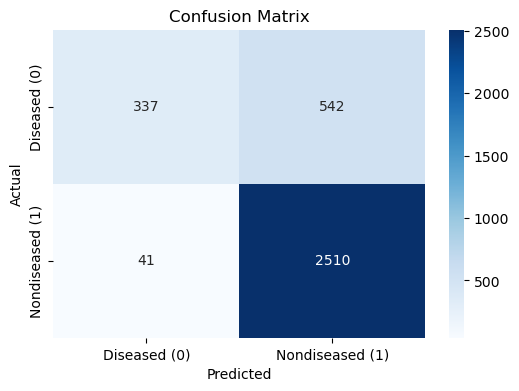

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

# load saved features and labels
x_train = np.load("/nmhs2/prema/imageprocessing/byol/features/x_train.npy")
y_train = np.load("/nmhs2/prema/imageprocessing/byol/features/y_train.npy")
x_test  = np.load("/nmhs2/prema/imageprocessing/byol/features/x_test.npy")
y_test  = np.load("/nmhs2/prema/imageprocessing/byol/features/y_test.npy")

# combine train + test
X = np.vstack([x_train, x_test])
y = np.hstack([y_train, y_test])

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred = kmeans.fit_predict(X)

# Align cluster labels with ground truth (diseased=0, nondiseased=1)
cm_raw = confusion_matrix(y, y_pred)
if cm_raw[0,0] + cm_raw[1,1] < cm_raw[0,1] + cm_raw[1,0]:
    y_pred = 1 - y_pred  # flip

# Final confusion matrix
cm = confusion_matrix(y, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# Plot heatmap with accuracy in the title
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Diseased (0)", "Nondiseased (1)"],
            yticklabels=["Diseased (0)", "Nondiseased (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix")
plt.show()
